# Imports

In [1]:
import cv2
import glob
import numpy as np
import pandas as pd
import os, sys, time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
%matplotlib inline

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

import tqdm
from PIL import Image
import seaborn as sns

from collections import OrderedDict

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.np_utils import to_categorical

from keras.utils import np_utils
from keras.optimizers import RMSprop
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Input, BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, balanced_accuracy_score

Using TensorFlow backend.


**Tensorflow logger levels**

* 0 - DEBUG - [Default] Print all messages
* 1 - INFO - Filter out INFO messages
* 2 - WARNING - Filter out INFO & WARNING messages
* 3 - ERROR - Filter out all messages

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Definição de classes e funções auxiliares

In [3]:
def plotLabelsDist(labels):
    plt.figure(figsize=(15,12))
    labels = sns.barplot(x=labels.value_counts().index,y=labels.value_counts())
    for item in labels.get_xticklabels():
        item.set_rotation(45)

### Classe LabelsConverter: responsável por salvar as conversões entre labels para facilitar a identificação posterior

In [4]:
class LabelsConverter:
    # Inicia conversor para carregar as informações em self.labels_convert
    def init_converter(self):
        for index, label in enumerate(self.original_labels):
            self.labels_convert.append({"label": label, "encoded": index, "categorical": [], "index_example": None})
    
    # Salva o índice de uma amostra de cada classe para referência posterior
    def save_labels_positions(self, y):
        for label in self.labels_convert:
            indexes = np.where(y == label["encoded"])
            label["index_example"] = indexes[0][0]
    
    # Salva, para cada label, o seu equivalente após a transformação em vetor categórico
    def save_categorical(self, y):
        for label in self.labels_convert:
            index = label["index_example"]
            label["categorical"] = y[index]
    
    # Recebe a representação de uma label em vetor categórico e retorna o seu valor legível original
    def find_by_categorical(self, categorical):
        for label in self.labels_convert:
            if np.array_equal(label["categorical"], categorical):
                return label["label"]

    # Exibe as informações salvas de cada label
    def print_conversor(self):
        for label in self.labels_convert:
            print(label)
    
    # Instancia a classe com os labels originals e codificados para int
    def __init__(self, encoded_labels, original_labels):
        self.encoded_labels = encoded_labels
        self.original_labels = original_labels
        self.labels_convert = []
        
        self.init_converter()

### Funções e classes para leitura e tratamento das imagens

In [5]:
# Recebe uma imagem e a retorna com o filtro aplicado
def filter (img):
    return img

In [6]:
# Realiza a leitura das imagens, aplica resize e os filtros e retorna um array com as imagens processadas
def prepareImages(train, image_size, channel, path, use_filter):
    shape = train.shape[0]
    dt_proc = np.zeros((shape, image_size, image_size, channel))
    
    for (index, fig) in enumerate(train['image']):
        img = cv2.imread("../input/resized-plant2021/"+path+"/"+fig)
        if(use_filter):
            img = filter(img)

        img = cv2.resize(img, (image_size, image_size))

        x = image.img_to_array(img)
        x = preprocess_input(x)

        dt_proc[index] = x
        if (index%500 == 0):
            print("Processando imagem: ", index+1, ", ", fig)
    
    return dt_proc

### Classe para visualização de gráficos relativos aos modelos

In [7]:
class HistoryPlot:
    # Plota a curva da perda no Treino
    def plot_loss(self):
        plt.plot(self.history['loss'], color='r', label="Train Loss")
        plt.title("Train Loss")
        plt.xlabel("Number of Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
    # Plota a curva da acurácia no Treino
    def plot_accuracy(self):
        plt.plot(self.history[self.acc_field], color='g', label="Train Accuracy")
        plt.title("Train Accuracy")
        plt.xlabel("Number of Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

    # Plota o valor da acurácia x o valor da perda
    def plot_loss_accuracy(self, X_test, Y_test):
        print('Perda de treino do modelo: ', self.history['loss'][-1])
        print('Acurácia de treino do modelo: ', self.history[self.acc_field][-1])

        score = self.model.evaluate(X_test, Y_test, verbose=0)
        print('Perda de teste do modelo:', score[0])
        print('Acurácia de teste do modelo:', score[1])

        plt.plot(self.history[self.acc_field])
        plt.plot(self.history['loss'])
        plt.title('Model Accuracy vs Loss')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Accuracy (' + str(round(score[1],2)) + ')', 'Loss (' + str(round(score[0],2)) + ')'], loc='upper left')
        plt.show()
    
    # Instancia a classe com o histórico e o modelo a ser avaliado
    def __init__(self, history, model):
        self.history = history.history
        self.model = model
        self.acc_field = 'acc'
        
        if 'accuracy' in history.history:
            self.acc_field = 'accuracy'

### Classes para mostrar as métricas de validação

In [8]:
# Recebe um array de predições as binariza
def binarize(y):
    for label in y:
        for index, n in enumerate(label):
            if n <= 0.5:
                label[index] = 0
            else:
                label[index] = 1
    
# Exibe as seguintes métricas em relação ao modelo: Precisão, revocação e F-medida
def print_metrics(model, X, y):
    predictions = model.predict(X)
    binarize(predictions)

    precision_score_res = precision_score(y.argmax(axis=1), predictions.argmax(axis=1), average='weighted')
    recall_score_res = recall_score(y.argmax(axis=1), predictions.argmax(axis=1), average='weighted')
    f1_score_res = f1_score(y.argmax(axis=1), predictions.argmax(axis=1), average='weighted')
    accuracy_score_res = accuracy_score(y.argmax(axis=1), predictions.argmax(axis=1))
    balanced_accuracy_score_res = balanced_accuracy_score(y.argmax(axis=1), predictions.argmax(axis=1))

    print("Precisão do modelo: ", precision_score_res)
    print("Revocação do modelo: ", recall_score_res)
    print("F-medida: ", f1_score_res)
    print("Acurácia: ", accuracy_score_res)
    print("Acurácia balanceada: ", balanced_accuracy_score_res)

In [9]:
def print_metrics_per_class(X, y, labels_converter, model):
    classes = {}
    for index, cat in enumerate(y):
        label = labels_converter.find_by_categorical(cat)
        
        if label not in classes:
            classes[label] = []
            
        classes[label].append(index)
    
    for _class in classes:
        class_X = X.take(classes[_class], axis=0)
        class_y = y.take(classes[_class], axis=0)
        
        print(f'classe {_class}, com {class_X.shape[0]} ocorrências:')
        print_metrics(model, class_X, class_y)
        print('-----------------------------\n')

# Define constantes de configurações a serem usados no projeto

In [10]:
# Configura o tamanho da imagem (altura e largura são iguais)
IMAGE_SIZE = 100

# Configura os canais de cada pixel (3 para R, G e B)
CHANNELS = 3

# Configura a representação de uma imagem baseado no tamanho e canais
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Configura o uso de filtro nas imagens
USE_FILTER = False

# Leitura dos dados e análise exploratória

#### As imagens de treino utilizadas são de uma coleção auxiliar de tamanho reduzido, para aumentar a velocidade de processamento e diminuir o uso de RAM

In [11]:
train_path = '../input/plant-pathology-2021-fgvc8/train.csv'
test_path = '../input/plant-pathology-2021-fgvc8/sample_submission.csv'
train_image_path = '../input/resized-plant2021/img_sz_640'
test_image_path = '../input/plant-pathology-2021-fgvc8/test_images'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

### Exibe os primeiros dados para treino

In [12]:
train.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


### Exibe os dados para teste

In [13]:
test.head()

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


### Exibe informação sobre o tamanho do dataset

In [14]:
print(f"O dataset de treino possui {len(os.listdir(train_image_path))} imagens, com {train.labels.nunique()} classes únicas.")
print(f"O dataset de treino possui {len(os.listdir(test_image_path))} imagens.")

O dataset de treino possui 18632 imagens, com 12 classes únicas.
O dataset de treino possui 3 imagens.


In [15]:
train.labels.value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

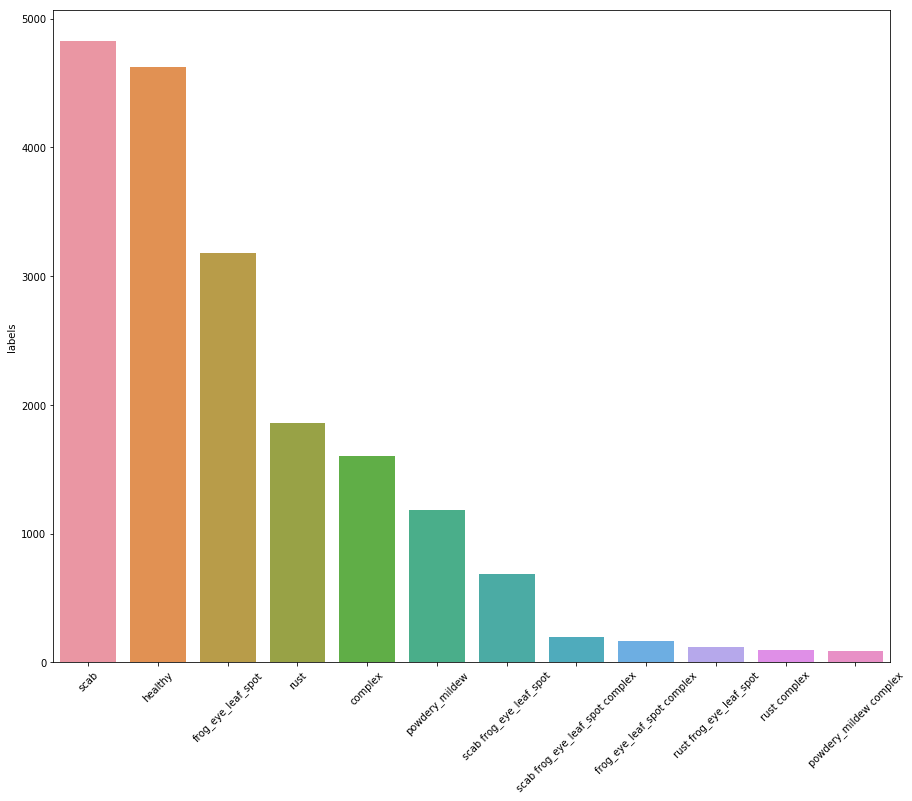

In [16]:
plotLabelsDist(train.labels)

### Carrega as imagens para memória, aplicando o pré-processamento definido

In [17]:
start = time.time()
dt_proc = prepareImages(train, IMAGE_SIZE, CHANNELS, "img_sz_640", USE_FILTER)
end = time.time()

elapsed = end - start
print(f"Imagens carregadas em: {elapsed} segundos.")

Processando imagem:  1 ,  800113bb65efe69e.jpg
Processando imagem:  501 ,  838397476a6b323d.jpg
Processando imagem:  1001 ,  870963e53fb5e023.jpg
Processando imagem:  1501 ,  8b9274cb3409f27d.jpg
Processando imagem:  2001 ,  905b6691423fc73d.jpg
Processando imagem:  2501 ,  9472e4d782deb192.jpg
Processando imagem:  3001 ,  972896b94aaba4b5.jpg
Processando imagem:  3501 ,  9cbe21bb0960e3e5.jpg
Processando imagem:  4001 ,  a0c0c2dad98d5ebd.jpg
Processando imagem:  4501 ,  a49b8711ad95a477.jpg
Processando imagem:  5001 ,  a6f1cac269679750.jpg
Processando imagem:  5501 ,  a9e4262e5db77482.jpg
Processando imagem:  6001 ,  ac4995f982d6ed12.jpg
Processando imagem:  6501 ,  aed2d487cc16cc99.jpg
Processando imagem:  7001 ,  b1e4c7830f1b5a72.jpg
Processando imagem:  7501 ,  b539ca5f5d691848.jpg
Processando imagem:  8001 ,  b84ff05dd401e6c9.jpg
Processando imagem:  8501 ,  bcf212f04abf5b10.jpg
Processando imagem:  9001 ,  bffb10816192a1fa.jpg
Processando imagem:  9501 ,  c1e068e15f4fb18d.jpg
Proc

### Normaliza os valores dos pixels para valores entre 0 e 1

In [18]:
dt_proc = dt_proc / 255.0

# Conversões dos rótulos

### Define a variável y contendo os rótulos e exibe suas informações

In [19]:
y = train["labels"]

print(y)
print(y.shape)

0                                healthy
1        scab frog_eye_leaf_spot complex
2                                   scab
3                                   scab
4                                complex
                      ...               
18627                            healthy
18628                               scab
18629                               rust
18630            scab frog_eye_leaf_spot
18631                            healthy
Name: labels, Length: 18632, dtype: object
(18632,)


In [20]:
y.describe()

count     18632
unique       12
top        scab
freq       4826
Name: labels, dtype: object

### Configura o número de labels que utilizaremos

In [21]:
NUM_LABELS = y.nunique()

print('NUM_LABELS: ', NUM_LABELS)

NUM_LABELS:  12


### Realiza uma codificação dos rótulos de texto para números inteiros

In [22]:
label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)
print(y_encoded)
print(y_encoded.shape)

[ 3 11  9 ...  6 10  3]
(18632,)


### Inicializa Labels Converter para facilitar a localização de rótulos

In [23]:
encoded_labels = list(range(0, NUM_LABELS))
original_labels = label_encoder.inverse_transform(encoded_labels)

labels_converter = LabelsConverter(encoded_labels, original_labels)
    
labels_converter.save_labels_positions(y_encoded)

### Transforma os rótulos de inteiros para vetores representando os rótulos categóricos

In [24]:
y_categorical = to_categorical(y_encoded, num_classes=NUM_LABELS)
print(y_categorical)
print(y_categorical.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(18632, 12)


### Adiciona as labels categoricas ao LabelConverter

In [25]:
labels_converter.save_categorical(y_categorical)
labels_converter.print_conversor()

{'label': 'complex', 'encoded': 0, 'categorical': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'index_example': 4}
{'label': 'frog_eye_leaf_spot', 'encoded': 1, 'categorical': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'index_example': 14}
{'label': 'frog_eye_leaf_spot complex', 'encoded': 2, 'categorical': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'index_example': 62}
{'label': 'healthy', 'encoded': 3, 'categorical': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'index_example': 0}
{'label': 'powdery_mildew', 'encoded': 4, 'categorical': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'index_example': 20}
{'label': 'powdery_mildew complex', 'encoded': 5, 'categorical': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32), 'index_example': 77}
{'label': 'rust', 'encoded': 6, 'categorical': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.

# Divisão do dataset entre Treino e Validação

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(dt_proc, y_categorical, test_size=0.2, random_state=42)

# CNN

### Define algumas configurações a serem usadas no modelo

In [27]:
LOSS_FUNCTION = 'categorical_crossentropy'

OPTIMIZER = 'Adam'

BATCH_SIZE = 4

EPOCHS = 10

### Define o modelo e suas camadas

In [28]:
cnn_model = Sequential()

cnn_model.add(Convolution2D(32, (3,3), activation='relu', padding='same', input_shape=IMG_SHAPE))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Convolution2D(64, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Convolution2D(128, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Convolution2D(256, (3,3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Flatten())
cnn_model.add(Dense(NUM_LABELS, activation='softmax'))

In [29]:
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)      

In [30]:
cnn_model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=["accuracy"])

### Treina o modelo

In [31]:
start = time.time()
cnn_histoy = cnn_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(X_test, Y_test))
end = time.time()
elapsed = end - start
print("Tempo de treino: ", elapsed)

Train on 14905 samples, validate on 3727 samples
Epoch 1/10
14905/14905 [==============================] - 26s 2ms/step - loss: 1.4805 - accuracy: 0.4586 - val_loss: 1.0454 - val_accuracy: 0.6329
Epoch 2/10
14905/14905 [==============================] - 24s 2ms/step - loss: 0.9355 - accuracy: 0.6872 - val_loss: 0.8216 - val_accuracy: 0.7354
Epoch 3/10
14905/14905 [==============================] - 24s 2ms/step - loss: 0.7235 - accuracy: 0.7613 - val_loss: 0.8030 - val_accuracy: 0.7489
Epoch 4/10
14905/14905 [==============================] - 24s 2ms/step - loss: 0.6130 - accuracy: 0.7926 - val_loss: 0.7262 - val_accuracy: 0.7797
Epoch 5/10
14905/14905 [==============================] - 24s 2ms/step - loss: 0.5165 - accuracy: 0.8247 - val_loss: 0.8177 - val_accuracy: 0.7733
Epoch 6/10
14905/14905 [==============================] - 24s 2ms/step - loss: 0.4116 - accuracy: 0.8596 - val_loss: 0.8290 - val_accuracy: 0.7821
Epoch 7/10
14905/14905 [==============================] - 25s 2ms/ste

### Exibe as métricas de avaliação do modelo

In [32]:
print_metrics(cnn_model, X_test, Y_test)

Precisão do modelo:  0.7449833140146279
Revocação do modelo:  0.7590555406493158
F-medida:  0.7494378373600334
Acurácia:  0.7590555406493158
Acurácia balanceada:  0.4064202729275888


In [33]:
print_metrics_per_class(X_test, Y_test, labels_converter, cnn_model)

classe healthy, com 964 ocorrências:


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.

Precisão do modelo:  1.0
Revocação do modelo:  0.8454356846473029
F-medida:  0.9162450815064642
Acurácia:  0.8454356846473029
Acurácia balanceada:  0.8454356846473029
-----------------------------

classe scab frog_eye_leaf_spot, com 135 ocorrências:
Precisão do modelo:  1.0
Revocação do modelo:  0.15555555555555556
F-medida:  0.2692307692307693
Acurácia:  0.15555555555555556
Acurácia balanceada:  0.15555555555555556
-----------------------------

classe scab frog_eye_leaf_spot complex, com 35 ocorrências:
Precisão do modelo:  1.0
Revocação do modelo:  0.02857142857142857
F-medida:  0.05555555555555556
Acurácia:  0.02857142857142857
Acurácia balanceada:  0.02857142857142857
-----------------------------

classe powdery_mildew complex, com 11 ocorrências:
Precisão do modelo:  0.0
Revocação do modelo:  0.0
F-medida:  0.0
Acurácia:  0.0
Acurácia balanceada:  0.0
-----------------------------

classe scab, com 942 ocorrências:
Precisão do modelo:  1.0
Revocação do modelo:  0.84394904458598

### Exibe os gráficos das métricas do modelo

In [34]:
history_plot = HistoryPlot(cnn_histoy, cnn_model)

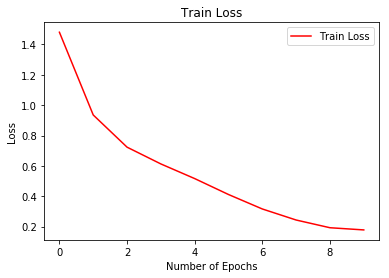

In [35]:
history_plot.plot_loss()

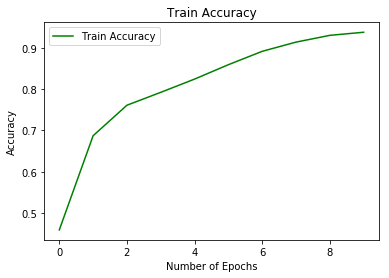

In [36]:
history_plot.plot_accuracy()

Perda de treino do modelo:  0.17839579538412276
Acurácia de treino do modelo:  0.9384099
Perda de teste do modelo: 1.2227671919158165
Acurácia de teste do modelo: 0.7620069980621338


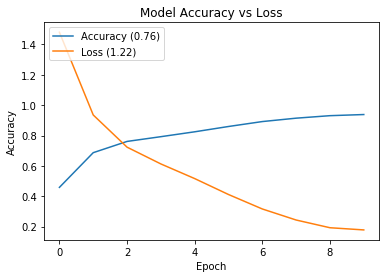

In [37]:
history_plot.plot_loss_accuracy(X_test, Y_test)

# MOBILE NET

In [38]:
# Create the base model from the pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')

base_model.trainable = False #Freeze the convolutional base

/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 1s 0us/step


In [39]:
mobile_net_model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(NUM_LABELS, activation='sigmoid')
])

mobile_net_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 3, 3, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                12300     
Total params: 3,241,164
Trainable params: 12,300
Non-trainable params: 3,228,864
_________________________________________________________________


In [40]:
mobile_net_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

In [41]:
epochs = 10

start = time.time()
mobile_net_history = mobile_net_model.fit(X_train, Y_train, epochs=epochs, batch_size=4, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

elapsed = end - start
print("Tempo de treino: ", elapsed)

Train on 14905 samples, validate on 3727 samples
Epoch 1/10
14905/14905 [==============================] - 27s 2ms/sample - loss: 1.8153 - acc: 0.3260 - val_loss: 2.1479 - val_acc: 0.3775
Epoch 2/10
14905/14905 [==============================] - 25s 2ms/sample - loss: 1.6973 - acc: 0.4293 - val_loss: 2.1538 - val_acc: 0.3982
Epoch 3/10
14905/14905 [==============================] - 24s 2ms/sample - loss: 1.6905 - acc: 0.4579 - val_loss: 2.1615 - val_acc: 0.4089
Epoch 4/10
14905/14905 [==============================] - 25s 2ms/sample - loss: 1.6775 - acc: 0.4538 - val_loss: 2.1409 - val_acc: 0.4022
Epoch 5/10
14905/14905 [==============================] - 25s 2ms/sample - loss: 1.6788 - acc: 0.4596 - val_loss: 2.1996 - val_acc: 0.4124
Epoch 6/10
14905/14905 [==============================] - 25s 2ms/sample - loss: 1.6809 - acc: 0.4592 - val_loss: 2.2636 - val_acc: 0.3807
Epoch 7/10
14905/14905 [==============================] - 25s 2ms/sample - loss: 1.6777 - acc: 0.4587 - val_loss: 2.3

### Exibe as métricas de avaliação do modelo

In [42]:
print_metrics(mobile_net_model, X_test, Y_test)

Precisão do modelo:  0.40196475957542405
Revocação do modelo:  0.18755030855916285
F-medida:  0.13715837031674769
Acurácia:  0.18755030855916285
Acurácia balanceada:  0.12067790506628238


In [43]:
print_metrics_per_class(X_test, Y_test, labels_converter, mobile_net_model)

classe healthy, com 964 ocorrências:
Precisão do modelo:  1.0
Revocação do modelo:  0.10062240663900415
F-medida:  0.1828463713477851
Acurácia:  0.10062240663900415
Acurácia balanceada:  0.10062240663900415
-----------------------------

classe scab frog_eye_leaf_spot, com 135 ocorrências:
Precisão do modelo:  0.0
Revocação do modelo:  0.0
F-medida:  0.0
Acurácia:  0.0
Acurácia balanceada:  0.0
-----------------------------

classe scab frog_eye_leaf_spot complex, com 35 ocorrências:
Precisão do modelo:  0.0
Revocação do modelo:  0.0
F-medida:  0.0
Acurácia:  0.0
Acurácia balanceada:  0.0
-----------------------------

classe powdery_mildew complex, com 11 ocorrências:
Precisão do modelo:  0.0
Revocação do modelo:  0.0
F-medida:  0.0
Acurácia:  0.0
Acurácia balanceada:  0.0
-----------------------------

classe scab, com 942 ocorrências:
Precisão do modelo:  1.0
Revocação do modelo:  0.014861995753715499
F-medida:  0.029288702928870293
Acurácia:  0.014861995753715499
Acurácia balancead

### Exibe os gráficos das métricas do modelo

In [44]:
history_plot = HistoryPlot(mobile_net_history, mobile_net_model)

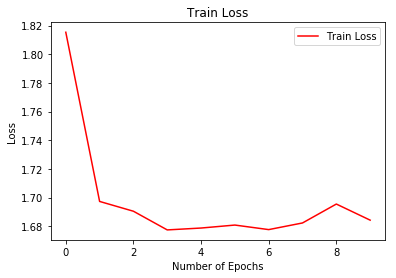

In [45]:
history_plot.plot_loss()

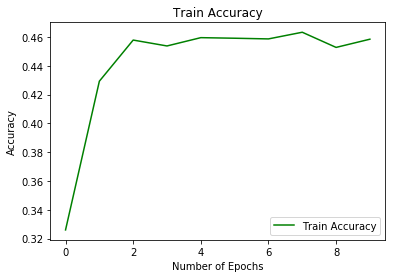

In [46]:
history_plot.plot_accuracy()

Perda de treino do modelo:  1.6842879893435043
Acurácia de treino do modelo:  0.45850387
Perda de teste do modelo: 2.1356090253180526
Acurácia de teste do modelo: 0.41561577


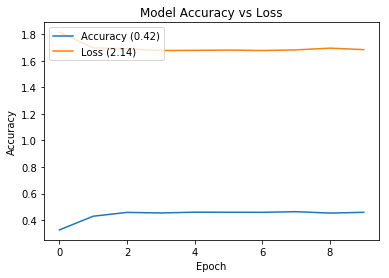

In [47]:
history_plot.plot_loss_accuracy(X_test, Y_test)

## Libera memória para os próximos modelos

In [48]:
dt_proc = 0
y = 0
y_encoded = 0
y_categorical = 0
X_train = 0
X_test = 0
Y_train = 0
Y_test = 0

cnn_model = 0
cnn_history = 0
mobile_net_model = 0
mobile_net_history = 0 

# Image Data Generator

## Preparação dos dados

In [49]:
HEIGHT = 448
WIDTH = 448
BATCH_SIZE = 32
SEED = 42
NUM_LABELS = 6

In [50]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [51]:
y = train['labels']
train_X, test_X, train_y, test_y = train_test_split(train, y, test_size=0.1, random_state=42, stratify=y)

y = train['labels']
mlb = MultiLabelBinarizer()
encoded = mlb.fit_transform(y.apply(lambda cat: cat.split(' ')))
labels = pd.DataFrame(encoded, columns=mlb.classes_, index=train.index)

print(labels.columns)

Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')


In [52]:
train = pd.concat([train['image'], labels], axis=1)
train.head()

,image,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,0,0,1,0,0,0
1,8002cb321f8bfcdf.jpg,1,1,0,0,0,1
2,80070f7fb5e2ccaa.jpg,0,0,0,0,0,1
3,80077517781fb94f.jpg,0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,1,0,0,0,0,0


In [53]:
train, test = train_test_split(train, test_size=0.1, random_state=SEED, shuffle=True)


## Configuração dos generators

In [54]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   vertical_flip=False)

train_dataset = train_datagen.flow_from_dataframe(train,
                                                  directory=train_image_path,
                                                  x_col="image",
                                                  y_col=train.columns.tolist()[1:],
                                                  target_size=(HEIGHT,WIDTH),
                                                  class_mode='raw',
                                                  batch_size=BATCH_SIZE,
                                                  subset="training",
                                                  shuffle=True,
                                                  seed=SEED,
                                                  validate_filenames=False)

Found 13415 non-validated image filenames.


In [55]:
validation_dataset = train_datagen.flow_from_dataframe(train,
                                                       directory=train_image_path,
                                                       x_col="image",
                                                       y_col=train.columns.tolist()[1:],
                                                       target_size=(HEIGHT,WIDTH),
                                                       class_mode='raw',
                                                       batch_size=BATCH_SIZE,
                                                       subset="validation",
                                                       shuffle=True,
                                                       seed=SEED,
                                                       validate_filenames=False)

Found 3353 non-validated image filenames.


In [56]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_dataset = test_datagen.flow_from_dataframe(test,
                                                directory=train_image_path,
                                                x_col='image',
                                                y_col=None,
                                                class_mode=None,
                                                shuffle=False,
                                                target_size=(HEIGHT,WIDTH))

Found 1864 validated image filenames.


## Models

### Model 1: CNN

In [57]:
cnn_model = Sequential()

cnn_model.add(Convolution2D(32,(3,3),activation='relu',padding='same',input_shape=(HEIGHT,WIDTH,3)))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Convolution2D(64,(3,3),activation='relu',padding='same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Convolution2D(128,(3,3),activation='relu',padding='same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Convolution2D(256,(3,3),activation='relu',padding='same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Flatten())
cnn_model.add(Dense(NUM_LABELS,activation='softmax'))

In [58]:
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 448, 448, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 256)      

In [59]:
cnn_model.compile(loss='binary_crossentropy', 
              optimizer='Adam',
              metrics=["accuracy"])

In [60]:
num_epochs = 10

start = time.time()
cnn_history = cnn_model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=num_epochs)
end = time.time()

elapsed = end - start
print("Tempo de treino: ", elapsed)

Epoch 1/10
420/420 [==============================] - 846s 2s/step - loss: 0.4434 - accuracy: 0.8181 - val_loss: 0.4235 - val_accuracy: 0.8203
Epoch 2/10
420/420 [==============================] - 837s 2s/step - loss: 0.4137 - accuracy: 0.8188 - val_loss: 0.3848 - val_accuracy: 0.8210
Epoch 3/10
420/420 [==============================] - 838s 2s/step - loss: 0.4029 - accuracy: 0.8222 - val_loss: 0.3964 - val_accuracy: 0.8258
Epoch 4/10
420/420 [==============================] - 840s 2s/step - loss: 0.3898 - accuracy: 0.8262 - val_loss: 0.3784 - val_accuracy: 0.8316
Epoch 5/10
420/420 [==============================] - 838s 2s/step - loss: 0.3829 - accuracy: 0.8290 - val_loss: 0.3552 - val_accuracy: 0.8326
Epoch 6/10
420/420 [==============================] - 839s 2s/step - loss: 0.3621 - accuracy: 0.8373 - val_loss: 0.3353 - val_accuracy: 0.8432
Epoch 7/10
420/420 [==============================] - 836s 2s/step - loss: 0.3265 - accuracy: 0.8541 - val_loss: 0.2476 - val_accuracy: 0.8589

### Model 2: MobileNet

In [61]:
# Create the base model from the pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=(HEIGHT,WIDTH,3),
                                             include_top=False,
                                             weights='imagenet')

base_model.trainable = False #Freeze the convolutional base

/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [62]:
mobile_net_model = tf.keras.Sequential([base_model,
                             tf.keras.layers.GlobalMaxPooling2D(),
                             tf.keras.layers.Dense(NUM_LABELS, activation='softmax')])

mobile_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 14, 14, 1024)      3228864   
_________________________________________________________________
global_max_pooling2d (Global (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 3,235,014
Trainable params: 6,150
Non-trainable params: 3,228,864
_________________________________________________________________


In [63]:
mobile_net_model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=["accuracy"])

In [64]:
num_epochs = 10

start = time.time()
mobile_net_history = mobile_net_model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=num_epochs)
end = time.time()

elapsed = end - start
print("Tempo de treino: ", elapsed)

Epoch 1/10
420/420 [==============================] - 866s 2s/step - loss: 0.7921 - acc: 0.7764 - val_loss: 0.9098 - val_acc: 0.7597
Epoch 2/10
420/420 [==============================] - 845s 2s/step - loss: 0.7421 - acc: 0.7897 - val_loss: 0.8680 - val_acc: 0.7729
Epoch 3/10
420/420 [==============================] - 851s 2s/step - loss: 0.7395 - acc: 0.7944 - val_loss: 1.0296 - val_acc: 0.7733
Epoch 4/10
420/420 [==============================] - 846s 2s/step - loss: 0.7093 - acc: 0.8026 - val_loss: 0.9740 - val_acc: 0.7786
Epoch 5/10
420/420 [==============================] - 849s 2s/step - loss: 0.6973 - acc: 0.8061 - val_loss: 1.1670 - val_acc: 0.7765
Epoch 6/10
420/420 [==============================] - 840s 2s/step - loss: 0.6996 - acc: 0.8075 - val_loss: 0.9998 - val_acc: 0.7882
Epoch 7/10
420/420 [==============================] - 847s 2s/step - loss: 0.6876 - acc: 0.8110 - val_loss: 1.1732 - val_acc: 0.7741
Epoch 8/10
420/420 [==============================] - 837s 2s/step - 